In [2]:
import numpy as np
import subprocess
import tqdm
import pandas as pd

import os
import os.path as osp

import glob

import h5py
import uproot

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random

In [3]:

v_path = '/vols/cms/bmaier/hgcal/data/20230701_multi_particles/test/raw/particles_10_8373759_ntuple.root'

In [4]:
import uproot
import matplotlib.pyplot as plt

# Open files
v_file = uproot.open(v_path)

# Inspect contents
print("Electron file contents:")
print(v_file.keys())


Electron file contents:
['ticlNtuplizer;1', 'ticlNtuplizer/tracksters;1', 'ticlNtuplizer/clusters;1', 'ticlNtuplizer/graph;1', 'ticlNtuplizer/candidates;1', 'ticlNtuplizer/trackstersMerged;1', 'ticlNtuplizer/associations;1', 'ticlNtuplizer/simtrackstersSC;1', 'ticlNtuplizer/simtrackstersCP;1', 'ticlNtuplizer/tracks;1']


In [7]:
keys_to_inspect = ["ticlNtuplizer/tracksters;1", "ticlNtuplizer/clusters;1", "ticlNtuplizer/simtrackstersCP;1", "ticlNtuplizer/trackstersMerged;1", "ticlNtuplizer/associations;1"]  # Add the keys you are interested in

for key in v_file.keys():
    if key in keys_to_inspect:
        print(f"Inspecting key: {key}")
        obj = v_file[key]
        
        # Check if the object is a tree or nested directory
        if hasattr(obj, "keys"):  # If it has keys, it can be expanded further
            print("Subkeys (branches or nested objects):")
            print(obj.keys())
        else:
            print(f"{key} is not a tree or expandable object.")
        print("-" * 50)

Inspecting key: ticlNtuplizer/tracksters;1
Subkeys (branches or nested objects):
['event', 'NClusters', 'NTracksters', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'trackster_barycenter_eta', 'trackster_barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity', 'layer_cluster_seed']
--------------------------------------------------
Inspecting key: ticlNtuplizer/clusters;1
Subkeys (branches or nested objects):
['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'c

In [48]:
import glob
import os.path as osp
import uproot
import awkward as ak
import torch
import numpy as np
import random
import tqdm
from torch_geometric.data import Data, Dataset

import numpy as np
import subprocess
import tqdm
import pandas as pd

import os
import os.path as osp

import glob

import h5py
import uproot

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random

class CCV1(Dataset):
    r'''
    Loads trackster-level features and associations for positive/negative edge creation.
    '''

    url = '/dummy/'

    def __init__(self, root, transform=None, max_events=1e8, inp='train'):
        super(CCV1, self).__init__(root, transform)
        self.inp = inp
        self.max_events = max_events
        self.fill_data(max_events)

    def fill_data(self, max_events):
        counter = 0
        print("### Loading tracksters data")

        # Choose paths depending on input mode
        if self.inp == 'train':
            tracksters_path = 'tracksters;1'
            associations_path = 'associations;1'
            simtrack = 'simtrackstersCP;3'
        elif self.inp == 'val':
            tracksters_path = 'tracksters;1'
            associations_path = 'associations;1'
            simtrack = 'simtrackstersCP;2'
        else:
            tracksters_path = 'ticlNtuplizer/tracksters;1'
            associations_path = 'ticlNtuplizer/associations;1'
            simtrack = 'ticlNtuplizer/simtrackstersCP;1'

        for path in tqdm.tqdm(self.raw_paths):
            # Load tracksters features in chunks
            for array in uproot.iterate(
                f"{path}:{tracksters_path}",
                [
                    "time", "raw_energy",
                    "barycenter_x", "barycenter_y", "barycenter_z", 
                    "trackster_barycenter_eta", "trackster_barycenter_phi",
                    "EV1", "EV2", "EV3",
                    "eVector0_x", "eVector0_y", "eVector0_z",
                    "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"
                ],
            ):

                tmp_time = array["time"]
                tmp_raw_energy = array["raw_energy"]
                tmp_bx = array["barycenter_x"]
                tmp_by = array["barycenter_y"]
                tmp_bz = array["barycenter_z"]
                tmp_beta = array["trackster_barycenter_eta"]
                tmp_bphi = array["trackster_barycenter_phi"]
                tmp_EV1 = array["EV1"]
                tmp_EV2 = array["EV2"]
                tmp_EV3 = array["EV3"]
                tmp_eV0x = array["eVector0_x"]
                tmp_eV0y = array["eVector0_y"]
                tmp_eV0z = array["eVector0_z"]
                tmp_sigma1 = array["sigmaPCA1"]
                tmp_sigma2 = array["sigmaPCA2"]
                tmp_sigma3 = array["sigmaPCA3"]
                
                
                vert_array = []
                for vert_chunk in uproot.iterate(
                    f"{path}:{simtrack}",
                    ["stsCP_barycenter_x"],
                ):
                    vert_array = vert_chunk["stsCP_barycenter_x"]
                    break  # Since we have a matching chunk, no need to continue
                

                # Now load the associations for the same events/chunk
                # 'tsCLUE3D_recoToSim_CP' gives association arrays like [[1,0],[0,1],...]
                # Make sure we read from the same events
                assoc_array = []
                for assoc_chunk in uproot.iterate(
                    f"{path}:{associations_path}",
                    ["tsCLUE3D_recoToSim_CP"],
                ):
                    assoc_array = assoc_chunk["tsCLUE3D_recoToSim_CP"]
                    break  # Since we have a matching chunk, no need to continue
                
                
                
                skim_mask = []
                for e in vert_array:
                    if len(e) == 2:
                        skim_mask.append(True)
                    else:
                        skim_mask.append(True)

                tmp_time = tmp_time[skim_mask]
                tmp_raw_energy = tmp_raw_energy[skim_mask]
                tmp_bx = tmp_bx[skim_mask]
                tmp_by = tmp_by[skim_mask]
                tmp_bz = tmp_bz[skim_mask]
                tmp_beta = tmp_beta[skim_mask]
                tmp_bphi = tmp_bphi[skim_mask]
                tmp_EV1 = tmp_EV1[skim_mask]
                tmp_EV2 = tmp_EV2[skim_mask]
                tmp_EV3 = tmp_EV3[skim_mask]
                tmp_eV0x = tmp_eV0x[skim_mask]
                tmp_eV0y = tmp_eV0y[skim_mask]
                tmp_eV0z = tmp_eV0z[skim_mask]
                tmp_sigma1 = tmp_sigma1[skim_mask]
                tmp_sigma2 = tmp_sigma2[skim_mask]
                tmp_sigma3 = tmp_sigma3[skim_mask]
                
                assoc_array = assoc_array[skim_mask]
                
                
                # Concatenate or initialize storage
                if counter == 0:
                    self.time = tmp_time
                    self.raw_energy = tmp_raw_energy
                    self.bx = tmp_bx
                    self.by = tmp_by
                    self.bz = tmp_bz
                    self.beta = tmp_beta
                    self.bphi = tmp_bphi
                    self.EV1 = tmp_EV1
                    self.EV2 = tmp_EV2
                    self.EV3 = tmp_EV3
                    self.eV0x = tmp_eV0x
                    self.eV0y = tmp_eV0y
                    self.eV0z = tmp_eV0z
                    self.sigma1 = tmp_sigma1
                    self.sigma2 = tmp_sigma2
                    self.sigma3 = tmp_sigma3
                    self.assoc = assoc_array
                else:
                    self.time = ak.concatenate((self.time, tmp_time))
                    self.raw_energy = ak.concatenate((self.raw_energy, tmp_raw_energy))
                    self.bx = ak.concatenate((self.bx, tmp_bx))
                    self.by = ak.concatenate((self.by, tmp_by))
                    self.bz = ak.concatenate((self.bz, tmp_bz))
                    self.beta = ak.concatenate((self.beta, tmp_beta))
                    self.bphi = ak.concatenate((self.bphi, tmp_bphi))
                    self.EV1 = ak.concatenate((self.EV1, tmp_EV1))
                    self.EV2 = ak.concatenate((self.EV2, tmp_EV2))
                    self.EV3 = ak.concatenate((self.EV3, tmp_EV3))
                    self.eV0x = ak.concatenate((self.eV0x, tmp_eV0x))
                    self.eV0y = ak.concatenate((self.eV0y, tmp_eV0y))
                    self.eV0z = ak.concatenate((self.eV0z, tmp_eV0z))
                    self.sigma1 = ak.concatenate((self.sigma1, tmp_sigma1))
                    self.sigma2 = ak.concatenate((self.sigma2, tmp_sigma2))
                    self.sigma3 = ak.concatenate((self.sigma3, tmp_sigma3))
                    self.assoc = ak.concatenate((self.assoc, assoc_array))

                counter += len(tmp_time)
                if counter >= max_events:
                    print(f"Reached {max_events} events!")
                    break
            if counter >= max_events:
                break

    def download(self):
        raise RuntimeError(
            f'Dataset not found. Please download it from {self.url} and move all '
            f'*.root files to {self.raw_dir}')

    def len(self):
        return len(self.time)

    @property
    def raw_file_names(self):
        raw_files = sorted(glob.glob(osp.join(self.raw_dir, 'particles_10_8373759_ntuple.root')))
        return raw_files

    @property
    def processed_file_names(self):
        return []

    def get(self, idx):
        # Extract per-event arrays
        event_time = self.time[idx]
        event_raw_energy = self.raw_energy[idx]
        event_bx = self.bx[idx]
        event_by = self.by[idx]
        event_bz = self.bz[idx]
        event_beta = self.beta[idx]
        event_bphi = self.bphi[idx]
        event_EV1 = self.EV1[idx]
        event_EV2 = self.EV2[idx]
        event_EV3 = self.EV3[idx]
        event_eV0x = self.eV0x[idx]
        event_eV0y = self.eV0y[idx]
        event_eV0z = self.eV0z[idx]
        event_sigma1 = self.sigma1[idx]
        event_sigma2 = self.sigma2[idx]
        event_sigma3 = self.sigma3[idx]
        event_assoc = self.assoc[idx]  # Shape: [N_tracksters, 2], either [1,0] or [0,1]

        
        
        # Convert to numpy
        event_time = np.array(event_time)
        event_raw_energy = np.array(event_raw_energy)
        event_bx = np.array(event_bx)
        event_by = np.array(event_by)
        event_bz = np.array(event_bz)
        event_beta = np.array(event_beta)
        event_bphi = np.array(event_bphi)
        event_EV1 = np.array(event_EV1)
        event_EV2 = np.array(event_EV2)
        event_EV3 = np.array(event_EV3)
        event_eV0x = np.array(event_eV0x)
        event_eV0y = np.array(event_eV0y)
        event_eV0z = np.array(event_eV0z)
        event_sigma1 = np.array(event_sigma1)
        event_sigma2 = np.array(event_sigma2)
        event_sigma3 = np.array(event_sigma3)
        event_assoc = np.array(event_assoc)  # e.g. [[1,0],[0,1],...]
        
        
        # Combine features
        flat_feats = np.column_stack((
            event_bx, event_by, event_bz,event_raw_energy,
            event_beta, event_bphi,
            event_EV1, event_EV2, event_EV3,
            event_eV0x, event_eV0y, event_eV0z,
            event_sigma1, event_sigma2, event_sigma3
        ))

        x = torch.from_numpy(flat_feats).float()

        # Create positive and negative edges
        # Identify tracksters from particle A and B
        # A: [1,0], B: [0,1]
        # We'll store the indices of each particle
        particleA = [i for i,assoc in enumerate(event_assoc) if assoc[0] == 1 and assoc[1] == 0]
        particleB = [i for i,assoc in enumerate(event_assoc) if assoc[0] == 0 and assoc[1] == 1]

        pos_edges = []
        neg_edges = []
        total_tracksters = len(event_time)

        # Function to get a random trackster from the same particle (allow self if only one)
        # Function to get a random trackster from the same particle (allow self if only one)
        def get_positive_target(curr_idx, same_particle_list):
            if not same_particle_list:
                # If no tracksters in the same particle (edge case), fall back to self
                return curr_idx
            if len(same_particle_list) == 1:
                # Only one trackster in this particle, must link to itself
                return curr_idx
            else:
                target = random.choice(same_particle_list)
                while target == curr_idx:
                    target = random.choice(same_particle_list)
                return target

        # Function to get a random trackster from the other particle
        def get_negative_target(curr_idx, other_particle_list):
            if not other_particle_list:
                # If no tracksters from the other particle, skip negative edge or link to self
                return curr_idx
            else:
                return random.choice(other_particle_list)

        # Create edges for each trackster
        for i in range(total_tracksters):
            # Determine which particle this trackster belongs to
            if i in particleA:
                pos_target = get_positive_target(i, particleA)
                neg_target = get_negative_target(i, particleB)
            else:
                # belongs to particle B
                pos_target = get_positive_target(i, particleB)
                neg_target = get_negative_target(i, particleA)

            pos_edges.append([i, pos_target])
            neg_edges.append([i, neg_target])

        x_pos_edge = torch.tensor(pos_edges, dtype=torch.long)
        x_neg_edge = torch.tensor(neg_edges, dtype=torch.long)
        
        return Data(x=x, x_pe=x_pos_edge, x_ne=x_neg_edge)

In [49]:
ipath = '/vols/cms/bmaier/hgcal/data/20230701_multi_particles/test/'

In [50]:
data_train = CCV1(ipath, max_events=100, inp = 'test')

### Loading tracksters data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


In [51]:
print(data_train)

CCV1(50)


In [54]:
print(data_train[0].x)

tensor([[-5.6941e-01, -8.1882e+01,  3.3236e+02,  5.2201e+00,  2.1089e+00,
         -1.5778e+00,  3.5094e+01,  1.4831e+00,  1.9524e-01, -2.1542e-02,
         -8.3329e-02,  9.9629e-01,  5.8689e+00,  1.3153e+00,  7.7347e-01],
        [ 2.9716e+01, -7.7850e+01,  3.3440e+02,  9.6431e+01,  2.0979e+00,
         -1.2062e+00,  4.0722e+01,  1.0208e+00,  2.0166e-01,  9.5873e-02,
         -1.9996e-01,  9.7510e-01,  6.0194e+00,  2.2825e+00,  7.0820e-01],
        [-3.1544e+01, -7.7493e+01,  3.3517e+02,  5.1046e+01,  2.0962e+00,
         -1.9574e+00,  3.8315e+01,  2.3671e-01,  1.3718e-01, -9.1894e-02,
         -2.1994e-01,  9.7117e-01,  5.4908e+00,  2.6847e+00,  1.1541e+00],
        [ 3.9372e+01, -7.4231e+01,  3.3691e+02,  2.9796e+02,  2.0970e+00,
         -1.0831e+00,  3.8567e+01,  5.1395e-02,  2.1358e-02,  1.0843e-01,
         -2.1062e-01,  9.7154e-01,  6.1441e+00,  2.7374e-01,  9.0226e-01],
        [-4.9966e+01, -6.7865e+01,  3.3846e+02,  4.6657e+01,  2.0986e+00,
         -2.2054e+00,  3.2295e+01,

In [10]:
# Iterate through all events and print positive edges
for i in range(len(data_train)):
    print(f"Event {i}: Positive Edges (x_pe)")
    print(data_train[i].x_pe)  # Print the positive edges for event i
    print("-" * 50)  # Separator for readability

Event 0: Positive Edges (x_pe)
tensor([[0, 4],
        [1, 5],
        [2, 5],
        [3, 6],
        [4, 1],
        [5, 2],
        [6, 3]])
--------------------------------------------------
Event 1: Positive Edges (x_pe)
tensor([[ 0,  3],
        [ 1, 10],
        [ 2, 11],
        [ 3,  0],
        [ 4,  2],
        [ 5, 10],
        [ 6,  7],
        [ 7,  5],
        [ 8,  5],
        [ 9,  1],
        [10,  1],
        [11,  4],
        [12,  3]])
--------------------------------------------------
Event 2: Positive Edges (x_pe)
tensor([[ 0,  0],
        [ 1,  3],
        [ 2,  5],
        [ 3,  7],
        [ 4,  1],
        [ 5,  1],
        [ 6,  1],
        [ 7, 10],
        [ 8,  4],
        [ 9, 10],
        [10,  7]])
--------------------------------------------------
Event 3: Positive Edges (x_pe)
tensor([[ 0,  5],
        [ 1,  6],
        [ 2, 13],
        [ 3,  0],
        [ 4,  9],
        [ 5,  0],
        [ 6, 11],
        [ 7, 13],
        [ 8, 10],
        [ 9, 1

tensor([[ 0,  2],
        [ 1,  9],
        [ 2,  4],
        [ 3,  0],
        [ 4,  6],
        [ 5,  9],
        [ 6,  2],
        [ 7,  8],
        [ 8,  7],
        [ 9,  0],
        [10,  9]])
--------------------------------------------------
Event 51: Positive Edges (x_pe)
tensor([[0, 5],
        [1, 0],
        [2, 4],
        [3, 0],
        [4, 2],
        [5, 1],
        [6, 4]])
--------------------------------------------------
Event 52: Positive Edges (x_pe)
tensor([[0, 0],
        [1, 2],
        [2, 3],
        [3, 2],
        [4, 5],
        [5, 7],
        [6, 1],
        [7, 1]])
--------------------------------------------------
Event 53: Positive Edges (x_pe)
tensor([[ 0, 10],
        [ 1,  0],
        [ 2,  8],
        [ 3,  2],
        [ 4,  7],
        [ 5,  4],
        [ 6,  7],
        [ 7,  9],
        [ 8,  7],
        [ 9,  4],
        [10,  0],
        [11,  6]])
--------------------------------------------------
Event 54: Positive Edges (x_pe)
tensor([[ 

tensor([[0, 3],
        [1, 6],
        [2, 0],
        [3, 1],
        [4, 5],
        [5, 4],
        [6, 3]])
--------------------------------------------------
Event 103: Positive Edges (x_pe)
tensor([[ 0,  6],
        [ 1,  4],
        [ 2,  6],
        [ 3,  7],
        [ 4,  5],
        [ 5,  1],
        [ 6,  7],
        [ 7,  3],
        [ 8, 11],
        [ 9,  8],
        [10, 11],
        [11,  8],
        [12,  7]])
--------------------------------------------------
Event 104: Positive Edges (x_pe)
tensor([[0, 3],
        [1, 2],
        [2, 1],
        [3, 1],
        [4, 7],
        [5, 8],
        [6, 8],
        [7, 8],
        [8, 6],
        [9, 4]])
--------------------------------------------------
Event 105: Positive Edges (x_pe)
tensor([[0, 2],
        [1, 5],
        [2, 0],
        [3, 5],
        [4, 1],
        [5, 1],
        [6, 2]])
--------------------------------------------------
Event 106: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
      

tensor([[ 0,  8],
        [ 1,  9],
        [ 2,  6],
        [ 3,  0],
        [ 4, 13],
        [ 5,  4],
        [ 6,  8],
        [ 7,  4],
        [ 8, 13],
        [ 9,  6],
        [10, 14],
        [11, 19],
        [12,  5],
        [13,  4],
        [14, 22],
        [15, 17],
        [16,  3],
        [17, 24],
        [18, 20],
        [19, 23],
        [20, 21],
        [21, 14],
        [22, 24],
        [23, 21],
        [24, 10]])
--------------------------------------------------
Event 154: Positive Edges (x_pe)
tensor([[ 0,  2],
        [ 1,  7],
        [ 2,  5],
        [ 3,  2],
        [ 4,  7],
        [ 5,  4],
        [ 6, 12],
        [ 7,  5],
        [ 8, 10],
        [ 9,  8],
        [10,  9],
        [11, 12],
        [12,  8],
        [13, 14],
        [14, 11]])
--------------------------------------------------
Event 155: Positive Edges (x_pe)
tensor([[ 0,  5],
        [ 1,  6],
        [ 2,  2],
        [ 3,  5],
        [ 4,  0],
        [ 5,  6],
  

tensor([[ 0, 10],
        [ 1,  4],
        [ 2,  0],
        [ 3,  1],
        [ 4, 10],
        [ 5,  8],
        [ 6,  3],
        [ 7, 11],
        [ 8,  7],
        [ 9, 11],
        [10,  2],
        [11,  8],
        [12,  7]])
--------------------------------------------------
Event 207: Positive Edges (x_pe)
tensor([[ 0, 11],
        [ 1,  4],
        [ 2,  5],
        [ 3, 10],
        [ 4,  7],
        [ 5,  1],
        [ 6,  8],
        [ 7, 11],
        [ 8,  0],
        [ 9, 13],
        [10,  0],
        [11,  2],
        [12,  9],
        [13, 12],
        [14, 13],
        [15, 13]])
--------------------------------------------------
Event 208: Positive Edges (x_pe)
tensor([[ 0,  7],
        [ 1, 10],
        [ 2, 14],
        [ 3,  5],
        [ 4,  3],
        [ 5,  4],
        [ 6,  0],
        [ 7,  1],
        [ 8, 14],
        [ 9, 15],
        [10,  0],
        [11, 13],
        [12,  7],
        [13,  7],
        [14,  0],
        [15,  8]])
-------------------

tensor([[0, 0],
        [1, 2],
        [2, 1]])
--------------------------------------------------
Event 260: Positive Edges (x_pe)
tensor([[ 0, 16],
        [ 1, 14],
        [ 2,  5],
        [ 3,  2],
        [ 4, 16],
        [ 5, 16],
        [ 6,  8],
        [ 7, 11],
        [ 8, 10],
        [ 9,  6],
        [10,  7],
        [11,  6],
        [12, 16],
        [13,  2],
        [14, 13],
        [15,  9],
        [16,  2],
        [17,  8]])
--------------------------------------------------
Event 261: Positive Edges (x_pe)
tensor([[ 0,  8],
        [ 1,  3],
        [ 2,  9],
        [ 3,  6],
        [ 4,  9],
        [ 5,  7],
        [ 6,  1],
        [ 7, 12],
        [ 8,  6],
        [ 9,  3],
        [10,  5],
        [11,  3],
        [12,  7]])
--------------------------------------------------
Event 262: Positive Edges (x_pe)
tensor([[0, 4],
        [1, 2],
        [2, 0],
        [3, 5],
        [4, 2],
        [5, 3],
        [6, 0]])
--------------------------

tensor([[ 0, 10],
        [ 1,  2],
        [ 2,  9],
        [ 3,  6],
        [ 4,  3],
        [ 5,  6],
        [ 6,  2],
        [ 7,  5],
        [ 8, 11],
        [ 9,  2],
        [10, 11],
        [11,  8]])
--------------------------------------------------
Event 313: Positive Edges (x_pe)
tensor([[ 0,  7],
        [ 1,  8],
        [ 2, 10],
        [ 3,  4],
        [ 4,  6],
        [ 5,  7],
        [ 6,  4],
        [ 7,  1],
        [ 8,  5],
        [ 9, 12],
        [10, 12],
        [11,  2],
        [12, 10]])
--------------------------------------------------
Event 314: Positive Edges (x_pe)
tensor([[0, 2],
        [1, 1],
        [2, 0],
        [3, 0]])
--------------------------------------------------
Event 315: Positive Edges (x_pe)
tensor([[ 0,  4],
        [ 1,  9],
        [ 2,  4],
        [ 3,  7],
        [ 4,  1],
        [ 5,  3],
        [ 6,  5],
        [ 7, 10],
        [ 8, 12],
        [ 9,  1],
        [10,  5],
        [11,  6],
        [12,  7

tensor([[ 0, 14],
        [ 1,  9],
        [ 2, 16],
        [ 3, 15],
        [ 4, 12],
        [ 5, 13],
        [ 6, 14],
        [ 7, 13],
        [ 8, 10],
        [ 9,  0],
        [10,  5],
        [11,  3],
        [12, 15],
        [13,  1],
        [14,  0],
        [15, 12],
        [16,  3]])
--------------------------------------------------
Event 365: Positive Edges (x_pe)
tensor([[ 0,  5],
        [ 1, 16],
        [ 2,  1],
        [ 3, 18],
        [ 4, 12],
        [ 5, 17],
        [ 6,  1],
        [ 7, 14],
        [ 8,  3],
        [ 9, 16],
        [10,  9],
        [11,  6],
        [12, 18],
        [13,  2],
        [14, 13],
        [15, 10],
        [16,  7],
        [17,  1],
        [18,  3],
        [19,  6]])
--------------------------------------------------
Event 366: Positive Edges (x_pe)
tensor([[0, 5],
        [1, 5],
        [2, 1],
        [3, 4],
        [4, 0],
        [5, 3],
        [6, 7],
        [7, 6],
        [8, 7]])
-------------------

tensor([[0, 1],
        [1, 0]])
--------------------------------------------------
Event 418: Positive Edges (x_pe)
tensor([[ 0, 14],
        [ 1, 13],
        [ 2, 10],
        [ 3, 21],
        [ 4, 19],
        [ 5, 17],
        [ 6, 22],
        [ 7, 16],
        [ 8, 10],
        [ 9, 12],
        [10,  9],
        [11,  1],
        [12, 10],
        [13,  4],
        [14,  6],
        [15, 13],
        [16, 18],
        [17, 12],
        [18,  4],
        [19,  4],
        [20, 15],
        [21, 19],
        [22, 12]])
--------------------------------------------------
Event 419: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  4],
        [ 2,  1],
        [ 3, 12],
        [ 4,  9],
        [ 5,  0],
        [ 6,  0],
        [ 7, 11],
        [ 8,  3],
        [ 9,  0],
        [10,  7],
        [11, 12],
        [12, 13],
        [13, 12],
        [14, 15],
        [15,  7],
        [16,  7]])
--------------------------------------------------
Event 420: Positive Edges 

tensor([[ 0,  1],
        [ 1,  0],
        [ 2,  6],
        [ 3,  5],
        [ 4,  3],
        [ 5,  4],
        [ 6,  3],
        [ 7,  3],
        [ 8,  5],
        [ 9,  3],
        [10,  5],
        [11,  3],
        [12,  6],
        [13,  3],
        [14,  2],
        [15,  4],
        [16,  4],
        [17,  5],
        [18,  5],
        [19,  5],
        [20,  2],
        [21,  3],
        [22,  5],
        [23,  6],
        [24,  2],
        [25,  4],
        [26,  3]])
--------------------------------------------------
Event 471: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 2],
        [2, 3],
        [3, 2],
        [4, 7]])
--------------------------------------------------
Event 472: Positive Edges (x_pe)
tensor([[ 0,  2],
        [ 1,  3],
        [ 2,  4],
        [ 3,  4],
        [ 4,  2],
        [ 5,  9],
        [ 6,  9],
        [ 7,  8],
        [ 8, 10],
        [ 9,  6],
        [10,  5],
        [11, 10],
        [12,  6],
        [13,  7]])
-----------

tensor([[0, 7],
        [1, 3],
        [2, 1],
        [3, 7]])
--------------------------------------------------
Event 524: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 4],
        [2, 5],
        [3, 2],
        [4, 5],
        [5, 2],
        [6, 3],
        [7, 8]])
--------------------------------------------------
Event 525: Positive Edges (x_pe)
tensor([[ 0,  3],
        [ 1,  3],
        [ 2,  8],
        [ 3,  6],
        [ 4,  5],
        [ 5,  3],
        [ 6,  0],
        [ 7,  9],
        [ 8,  3],
        [ 9,  2],
        [10, 12],
        [11, 10],
        [12, 10],
        [13,  6]])
--------------------------------------------------
Event 526: Positive Edges (x_pe)
tensor([[ 0,  8],
        [ 1, 11],
        [ 2, 13],
        [ 3,  5],
        [ 4,  5]])
--------------------------------------------------
Event 527: Positive Edges (x_pe)
tensor([[ 0,  4],
        [ 1,  4],
        [ 2,  4],
        [ 3,  5],
        [ 4,  2],
        [ 5, 10],
        [ 6,  9],


tensor([[ 0,  9],
        [ 1, 11],
        [ 2, 15],
        [ 3,  6],
        [ 4,  7],
        [ 5, 15],
        [ 6,  7],
        [ 7,  6],
        [ 8,  2]])
--------------------------------------------------
Event 577: Positive Edges (x_pe)
tensor([[ 0, 10],
        [ 1,  6],
        [ 2,  4],
        [ 3,  2],
        [ 4, 10],
        [ 5, 10],
        [ 6,  5],
        [ 7, 12],
        [ 8, 13],
        [ 9,  7],
        [10,  1],
        [11, 10],
        [12, 16]])
--------------------------------------------------
Event 578: Positive Edges (x_pe)
tensor([[ 0, 12],
        [ 1,  6],
        [ 2,  5],
        [ 3, 14],
        [ 4,  7],
        [ 5,  0]])
--------------------------------------------------
Event 579: Positive Edges (x_pe)
tensor([[ 0,  3],
        [ 1,  6],
        [ 2,  5],
        [ 3,  5],
        [ 4,  2],
        [ 5,  4],
        [ 6,  1],
        [ 7,  3],
        [ 8,  5],
        [ 9,  4],
        [10,  0],
        [11,  0],
        [12,  2]])
------

tensor([[ 0,  6],
        [ 1,  3],
        [ 2,  5],
        [ 3,  6],
        [ 4,  3],
        [ 5,  3],
        [ 6,  2],
        [ 7,  8],
        [ 8,  7],
        [ 9,  7],
        [10,  5],
        [11,  4]])
--------------------------------------------------
Event 630: Positive Edges (x_pe)
tensor([[ 0,  2],
        [ 1,  2],
        [ 2,  1],
        [ 3,  3],
        [ 4,  2],
        [ 5,  1],
        [ 6,  2],
        [ 7,  2],
        [ 8,  2],
        [ 9,  1],
        [10,  0],
        [11,  1],
        [12,  1],
        [13,  0],
        [14,  2],
        [15,  2],
        [16,  0],
        [17,  0]])
--------------------------------------------------
Event 631: Positive Edges (x_pe)
tensor([[ 0,  8],
        [ 1,  4],
        [ 2,  5],
        [ 3,  8],
        [ 4,  1],
        [ 5,  4],
        [ 6,  5],
        [ 7,  3],
        [ 8,  3],
        [ 9,  3],
        [10,  7],
        [11,  7]])
--------------------------------------------------
Event 632: Positive Ed

tensor([[0, 0],
        [1, 5],
        [2, 6],
        [3, 1],
        [4, 6]])
--------------------------------------------------
Event 682: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0]])
--------------------------------------------------
Event 683: Positive Edges (x_pe)
tensor([[ 0,  8],
        [ 1,  3],
        [ 2,  2],
        [ 3,  5],
        [ 4, 11],
        [ 5, 12],
        [ 6,  0],
        [ 7,  8],
        [ 8,  9],
        [ 9,  1],
        [10,  5]])
--------------------------------------------------
Event 684: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
        [ 2,  4],
        [ 3,  2],
        [ 4,  2],
        [ 5,  3],
        [ 6,  2],
        [ 7,  3],
        [ 8,  2],
        [ 9,  4],
        [10,  3],
        [11,  4]])
--------------------------------------------------
Event 685: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0],
        [2, 2],
        [3, 3],
        [4, 4],
        [5, 5],
        [6, 6],
        [7, 7],
      

--------------------------------------------------
Event 729: Positive Edges (x_pe)
tensor([[ 0, 15],
        [ 1,  3],
        [ 2, 16],
        [ 3, 16],
        [ 4, 12],
        [ 5,  4],
        [ 6,  2],
        [ 7, 18],
        [ 8, 18],
        [ 9, 18],
        [10, 17],
        [11,  9],
        [12, 17],
        [13,  9]])
--------------------------------------------------
Event 730: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0],
        [2, 4],
        [3, 4]])
--------------------------------------------------
Event 731: Positive Edges (x_pe)
tensor([[0, 7]])
--------------------------------------------------
Event 732: Positive Edges (x_pe)
tensor([[ 0, 17],
        [ 1, 17],
        [ 2,  0],
        [ 3, 10],
        [ 4, 16],
        [ 5, 11],
        [ 6,  5],
        [ 7,  0],
        [ 8, 20],
        [ 9, 17],
        [10,  1]])
--------------------------------------------------
Event 733: Positive Edges (x_pe)
tensor([], dtype=torch.int64)
----------------

tensor([[0, 0],
        [1, 2],
        [2, 1],
        [3, 3],
        [4, 4],
        [5, 5],
        [6, 6]])
--------------------------------------------------
Event 779: Positive Edges (x_pe)
tensor([[ 0,  7],
        [ 1,  2],
        [ 2,  9],
        [ 3, 10],
        [ 4,  7],
        [ 5, 10],
        [ 6,  9],
        [ 7,  4],
        [ 8,  5],
        [ 9,  3],
        [10,  1]])
--------------------------------------------------
Event 780: Positive Edges (x_pe)
tensor([[ 0,  9],
        [ 1, 11],
        [ 2,  0],
        [ 3,  6],
        [ 4, 11],
        [ 5,  8],
        [ 6,  8],
        [ 7, 14],
        [ 8,  4],
        [ 9, 10],
        [10, 12],
        [11, 12],
        [12, 11]])
--------------------------------------------------
Event 781: Positive Edges (x_pe)
tensor([], dtype=torch.int64)
--------------------------------------------------
Event 782: Positive Edges (x_pe)
tensor([[ 0,  4],
        [ 1,  5],
        [ 2,  3],
        [ 3,  2],
        [ 4,  0

--------------------------------------------------
Event 826: Positive Edges (x_pe)
tensor([[0, 5],
        [1, 3],
        [2, 7],
        [3, 1],
        [4, 7],
        [5, 2],
        [6, 4],
        [7, 9],
        [8, 6]])
--------------------------------------------------
Event 827: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0],
        [2, 4],
        [3, 5],
        [4, 2],
        [5, 6],
        [6, 3],
        [7, 0],
        [8, 9],
        [9, 2]])
--------------------------------------------------
Event 828: Positive Edges (x_pe)
tensor([[ 0,  9],
        [ 1, 18],
        [ 2,  3]])
--------------------------------------------------
Event 829: Positive Edges (x_pe)
tensor([[ 0,  5],
        [ 1,  5],
        [ 2,  3],
        [ 3,  2],
        [ 4, 15],
        [ 5,  2],
        [ 6, 14],
        [ 7,  8]])
--------------------------------------------------
Event 830: Positive Edges (x_pe)
tensor([[ 0,  5],
        [ 1,  3],
        [ 2,  4],
        [ 3,  4],
  

tensor([[0, 0],
        [1, 4],
        [2, 1],
        [3, 2],
        [4, 5],
        [5, 4]])
--------------------------------------------------
Event 876: Positive Edges (x_pe)
tensor([[ 0, 17],
        [ 1,  2],
        [ 2, 22],
        [ 3, 14],
        [ 4,  9],
        [ 5, 19],
        [ 6,  7],
        [ 7, 11],
        [ 8, 14],
        [ 9, 12],
        [10,  1],
        [11, 17],
        [12,  9],
        [13,  1],
        [14,  9]])
--------------------------------------------------
Event 877: Positive Edges (x_pe)
tensor([[ 0, 14],
        [ 1,  6],
        [ 2, 10],
        [ 3, 16]])
--------------------------------------------------
Event 878: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
        [ 2,  3],
        [ 3,  2],
        [ 4,  3],
        [ 5,  2],
        [ 6,  3],
        [ 7,  4],
        [ 8,  2],
        [ 9,  3],
        [10,  2],
        [11,  4],
        [12,  3],
        [13,  4],
        [14,  3],
        [15,  3],
        [16,  3],
 

tensor([[0, 5],
        [1, 8],
        [2, 3],
        [3, 2],
        [4, 0],
        [5, 4],
        [6, 1]])
--------------------------------------------------
Event 929: Positive Edges (x_pe)
tensor([[ 0, 18],
        [ 1, 18],
        [ 2,  3],
        [ 3,  6],
        [ 4, 15],
        [ 5, 19],
        [ 6,  0],
        [ 7, 16],
        [ 8, 20],
        [ 9, 13],
        [10,  4]])
--------------------------------------------------
Event 930: Positive Edges (x_pe)
tensor([[ 0,  0],
        [ 1,  3],
        [ 2,  1],
        [ 3,  6],
        [ 4,  3],
        [ 5,  4],
        [ 6,  5],
        [ 7,  3],
        [ 8,  8],
        [ 9,  9],
        [10, 10],
        [11, 11],
        [12, 12],
        [13, 13],
        [14, 14],
        [15, 15]])
--------------------------------------------------
Event 931: Positive Edges (x_pe)
tensor([[ 0,  4],
        [ 1,  4],
        [ 2,  4],
        [ 3, 11],
        [ 4,  0],
        [ 5,  2],
        [ 6,  9],
        [ 7, 11],
   

tensor([[ 0,  2],
        [ 1,  0],
        [ 2,  0],
        [ 3,  4],
        [ 4,  6],
        [ 5,  3],
        [ 6,  3],
        [ 7,  2],
        [ 8,  1],
        [ 9,  0],
        [10,  2],
        [11,  1],
        [12,  1]])
--------------------------------------------------
Event 982: Positive Edges (x_pe)
tensor([[0, 5],
        [1, 0],
        [2, 5],
        [3, 2],
        [4, 5],
        [5, 1],
        [6, 3]])
--------------------------------------------------
Event 983: Positive Edges (x_pe)
tensor([[ 0, 21],
        [ 1, 21],
        [ 2, 16],
        [ 3, 14],
        [ 4, 14],
        [ 5, 19],
        [ 6,  8],
        [ 7, 13],
        [ 8, 16],
        [ 9, 10],
        [10,  4],
        [11,  7],
        [12,  9]])
--------------------------------------------------
Event 984: Positive Edges (x_pe)
tensor([[0, 7],
        [1, 6],
        [2, 5],
        [3, 2],
        [4, 6],
        [5, 7],
        [6, 2]])
--------------------------------------------------
E

tensor([[0, 2],
        [1, 4],
        [2, 4],
        [3, 1]])
--------------------------------------------------
Event 1030: Positive Edges (x_pe)
tensor([[0, 4],
        [1, 1],
        [2, 0],
        [3, 0],
        [4, 0],
        [5, 5],
        [6, 6],
        [7, 7]])
--------------------------------------------------
Event 1031: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
        [ 2,  4],
        [ 3,  4],
        [ 4,  3],
        [ 5,  6],
        [ 6,  2],
        [ 7,  4],
        [ 8,  3],
        [ 9,  4],
        [10,  7],
        [11,  7],
        [12,  6],
        [13,  4],
        [14,  7]])
--------------------------------------------------
Event 1032: Positive Edges (x_pe)
tensor([[ 0,  3],
        [ 1,  0],
        [ 2, 14],
        [ 3, 13],
        [ 4,  2],
        [ 5,  7],
        [ 6, 12]])
--------------------------------------------------
Event 1033: Positive Edges (x_pe)
tensor([[ 0,  0],
        [ 1,  6],
        [ 2,  6],
        [ 3, 1

tensor([[ 0,  3],
        [ 1,  6],
        [ 2,  5],
        [ 3,  8],
        [ 4,  5],
        [ 5,  1],
        [ 6,  2],
        [ 7,  8],
        [ 8,  0],
        [ 9,  7],
        [10,  7],
        [11,  8],
        [12,  3],
        [13,  8]])
--------------------------------------------------
Event 1080: Positive Edges (x_pe)
tensor([[0, 3],
        [1, 6],
        [2, 3],
        [3, 2],
        [4, 0],
        [5, 6]])
--------------------------------------------------
Event 1081: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
        [ 2,  8],
        [ 3,  6],
        [ 4,  5],
        [ 5,  4],
        [ 6,  5],
        [ 7,  4],
        [ 8,  5],
        [ 9,  2],
        [10,  8]])
--------------------------------------------------
Event 1082: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
        [ 2,  3],
        [ 3,  2],
        [ 4,  3],
        [ 5,  0],
        [ 6,  1],
        [ 7,  0],
        [ 8,  0],
        [ 9,  0],
        [10,  0]

tensor([[0, 1],
        [1, 0],
        [2, 4],
        [3, 2],
        [4, 2],
        [5, 2],
        [6, 3],
        [7, 4]])
--------------------------------------------------
Event 1133: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0]])
--------------------------------------------------
Event 1134: Positive Edges (x_pe)
tensor([], dtype=torch.int64)
--------------------------------------------------
Event 1135: Positive Edges (x_pe)
tensor([[ 0,  5],
        [ 1,  5],
        [ 2,  0],
        [ 3,  6],
        [ 4,  4],
        [ 5,  2],
        [ 6,  3],
        [ 7,  7],
        [ 8,  8],
        [ 9,  9],
        [10, 10],
        [11, 11],
        [12, 12]])
--------------------------------------------------
Event 1136: Positive Edges (x_pe)
tensor([[ 0,  3],
        [ 1,  4],
        [ 2,  3],
        [ 3,  2],
        [ 4,  0],
        [ 5,  0],
        [ 6,  5],
        [ 7, 10],
        [ 8,  4],
        [ 9,  3],
        [10,  7],
        [11, 10],
        [12, 10],

tensor([[0, 0]])
--------------------------------------------------
Event 1186: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 6],
        [2, 4],
        [3, 4],
        [4, 5],
        [5, 8],
        [6, 1],
        [7, 5]])
--------------------------------------------------
Event 1187: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 5],
        [2, 3],
        [3, 2]])
--------------------------------------------------
Event 1188: Positive Edges (x_pe)
tensor([[ 0,  3],
        [ 1, 15],
        [ 2,  9],
        [ 3,  9],
        [ 4, 18],
        [ 5,  6],
        [ 6, 12],
        [ 7, 16]])
--------------------------------------------------
Event 1189: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0]])
--------------------------------------------------
Event 1190: Positive Edges (x_pe)
tensor([[0, 0],
        [1, 2],
        [2, 1],
        [3, 1],
        [4, 2],
        [5, 2],
        [6, 1],
        [7, 2],
        [8, 2]])
-----------------------------------------

tensor([[0, 1],
        [1, 0],
        [2, 8],
        [3, 2],
        [4, 3]])
--------------------------------------------------
Event 1239: Positive Edges (x_pe)
tensor([[ 0,  6],
        [ 1,  2],
        [ 2, 12],
        [ 3,  1],
        [ 4, 16],
        [ 5, 11]])
--------------------------------------------------
Event 1240: Positive Edges (x_pe)
tensor([[ 0, 12],
        [ 1,  5],
        [ 2,  5],
        [ 3, 12],
        [ 4, 12],
        [ 5, 12],
        [ 6,  2],
        [ 7,  5],
        [ 8, 14],
        [ 9, 11]])
--------------------------------------------------
Event 1241: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 2]])
--------------------------------------------------
Event 1242: Positive Edges (x_pe)
tensor([[ 0,  1],
        [ 1,  0],
        [ 2, 16],
        [ 3, 15]])
--------------------------------------------------
Event 1243: Positive Edges (x_pe)
tensor([[ 0, 12],
        [ 1, 13],
        [ 2,  5],
        [ 3, 12],
        [ 4,  1],
        

tensor([[ 0,  4],
        [ 1, 11],
        [ 2,  7],
        [ 3,  9],
        [ 4,  8],
        [ 5,  6],
        [ 6,  5]])
--------------------------------------------------
Event 1291: Positive Edges (x_pe)
tensor([[ 0, 14],
        [ 1, 13],
        [ 2,  7],
        [ 3,  1],
        [ 4,  1],
        [ 5, 13],
        [ 6, 14],
        [ 7, 14],
        [ 8,  3]])
--------------------------------------------------
Event 1292: Positive Edges (x_pe)
tensor([[0, 0],
        [1, 7],
        [2, 8],
        [3, 7],
        [4, 2]])
--------------------------------------------------
Event 1293: Positive Edges (x_pe)
tensor([[0, 3],
        [1, 2],
        [2, 5],
        [3, 4],
        [4, 3],
        [5, 2],
        [6, 4],
        [7, 6],
        [8, 0],
        [9, 4]])
--------------------------------------------------
Event 1294: Positive Edges (x_pe)
tensor([[0, 1],
        [1, 0],
        [2, 3],
        [3, 4],
        [4, 3],
        [5, 2],
        [6, 1],
        [7, 0],


tensor([[ 0, 14],
        [ 1,  0],
        [ 2,  4],
        [ 3,  2],
        [ 4, 13],
        [ 5, 19]])
--------------------------------------------------


In [59]:
ass = v_file['ticlNtuplizer/associations;1']

In [73]:
print(ass.keys())

['tsCLUE3D_recoToSim_SC', 'tsCLUE3D_recoToSim_SC_score', 'tsCLUE3D_recoToSim_SC_sharedE', 'tsCLUE3D_simToReco_SC', 'tsCLUE3D_simToReco_SC_score', 'tsCLUE3D_simToReco_SC_sharedE', 'tsCLUE3D_recoToSim_CP', 'tsCLUE3D_recoToSim_CP_score', 'tsCLUE3D_recoToSim_CP_sharedE', 'tsCLUE3D_simToReco_CP', 'tsCLUE3D_simToReco_CP_score', 'tsCLUE3D_simToReco_CP_sharedE', 'Mergetstracksters_recoToSim_SC', 'Mergetstracksters_recoToSim_SC_score', 'Mergetstracksters_recoToSim_SC_sharedE', 'Mergetstracksters_simToReco_SC', 'Mergetstracksters_simToReco_SC_score', 'Mergetstracksters_simToReco_SC_sharedE', 'Mergetracksters_recoToSim_CP', 'Mergetracksters_recoToSim_CP_score', 'Mergetracksters_recoToSim_CP_sharedE', 'Mergetracksters_simToReco_CP', 'Mergetracksters_simToReco_CP_score', 'Mergetracksters_simToReco_CP_sharedE']


In [74]:
x = ass['tsCLUE3D_recoToSim_CP_score'].array()

In [75]:
print(len(x[0]))

31


In [76]:
print(x[0][11])

[0.048, 0.891, 1, 1, 1, 1, 1, 1, 1, 1]


In [77]:
MT = v_file['ticlNtuplizer/trackstersMerged;1']

In [78]:
print(MT.keys())

['event', 'NTracksters', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']


In [85]:
y = MT['barycenter_x'].array()

In [88]:
print(y[0])

[-2.02, 29.7, -31.5, 39.4, -50, -21.8, 20.1, ... 9.21, 18.6, 13.9, 3.85, 7.95, 24.8]


In [56]:
track = v_file['ticlNtuplizer/tracksters;1']

bx = track['barycenter_x'].array()
bz = track['barycenter_z'].array()
by = track['barycenter_y'].array()

In [67]:
print(len(bx[0]))

31


In [69]:
print(bx[0][0])

-0.5694124102592468


In [41]:
import numpy as np

# Target x-values to find (subset)
target_x = np.array([15.79, 13.17, 10.58, 11.75, 12.62, 13.67])  # Replace with your subset

# Loop through all events and search for a partial match
matching_index = None
for idx, event_x in enumerate(bx):  # Assuming bx contains barycenter_x values for all events
    event_x = np.array(event_x)  # Convert to numpy array for easy comparison
    # Check if target_x is a subset of the current event's x-values
    if all(any(np.isclose(tx, ex, atol=0.5) for ex in event_x) for tx in target_x):
        matching_index = idx
        break

# Output result
if matching_index is not None:
    print(f"Matching event found at index: {matching_index}")
else:
    print("No matching event found.")


Matching event found at index: 179


In [43]:
print(len(bx[179])

14


In [48]:
print(data_train[0].x)

tensor([[6.9639e+01, 8.5678e+01, 3.4644e+02, 1.0995e+01, 1.8612e+00, 8.8830e-01,
         3.3028e+01, 1.2369e+00, 7.3823e-01, 2.5070e-01, 3.0203e-01, 9.1974e-01,
         5.4417e+00, 1.2293e+00, 1.9696e+00],
        [7.0643e+01, 8.3631e+01, 3.5439e+02, 1.8685e+00, 1.8909e+00, 8.6939e-01,
         1.1957e+01, 1.6247e+00, 7.2083e-01, 1.7912e-01, 4.5070e-01, 8.7452e-01,
         2.5471e+00, 2.5038e+00, 1.2434e+00],
        [7.8384e+01, 9.9592e+01, 3.8113e+02, 9.9433e-01, 1.8207e+00, 9.0400e-01,
         1.0475e+02, 1.4602e+00, 1.2856e-12, 7.9202e-02, 2.4099e-01, 9.6729e-01,
         9.5132e+00, 3.6249e+00, 1.6038e+00],
        [7.3792e+01, 1.1619e+02, 3.7472e+02, 1.1300e+01, 1.7268e+00, 1.0050e+00,
         1.1287e+02, 1.2707e+00, 6.9958e-01, 2.4896e-01, 2.7219e-01, 9.2948e-01,
         9.7346e+00, 4.2149e+00, 1.5208e+00],
        [7.6696e+01, 9.3336e+01, 3.7586e+02, 2.9893e+00, 1.8531e+00, 8.8295e-01,
         1.5531e+02, 3.2958e-01, 1.6461e-01, 2.4556e-01, 2.2801e-01, 9.4218e-01,
      

In [17]:
sim = v_file['simtrackstersCP;3']

vx = sim['barycenter_x'].array()
vz = sim['barycenter_z'].array()
vy = sim['barycenter_y'].array() 

In [18]:
print(vx[12])

[74.7]


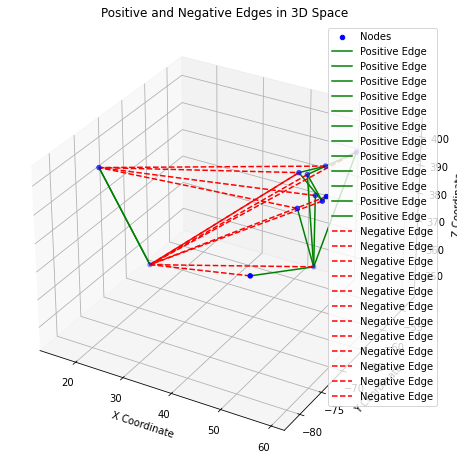

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def plot_edges_3d(data):
    """
    Visualizes the positive and negative edges in 3D space using the first 3 columns of data.x.
    
    Args:
        data: Data object with 'x', 'x_pe' (positive edges), and 'x_ne' (negative edges).
    """
    # Extract x, y, z coordinates
    xyz = data.x[:, :3].numpy()  # Shape: [N, 3]
    x_coords, y_coords, z_coords = xyz[:, 0], xyz[:, 1], xyz[:, 2]

    # Positive edges (x_pe) and negative edges (x_ne)
    pos_edges = data.x_pe.numpy()  # Positive edges (pairs of node indices)
    neg_edges = data.x_ne.numpy()  # Negative edges (pairs of node indices)

    # Initialize 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o', s=20, label='Nodes')

    # Plot positive edges (Green)
    for edge in pos_edges:
        start, end = edge
        ax.plot(
            [x_coords[start], x_coords[end]],
            [y_coords[start], y_coords[end]],
            [z_coords[start], z_coords[end]],
            color='g', linewidth=1.5, label='Positive Edge'
        )

    # Plot negative edges (Red)
    for edge in neg_edges:
        start, end = edge
        ax.plot(
            [x_coords[start], x_coords[end]],
            [y_coords[start], y_coords[end]],
            [z_coords[start], z_coords[end]],
            color='r', linestyle='--', linewidth=1.5, label='Negative Edge'
        )

    # Set plot labels
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Z Coordinate")
    ax.set_title("Positive and Negative Edges in 3D Space")
    ax.legend()

    # Show plot
    plt.show()

# Example usage with data_train[0]
plot_edges_3d(data_train[179])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


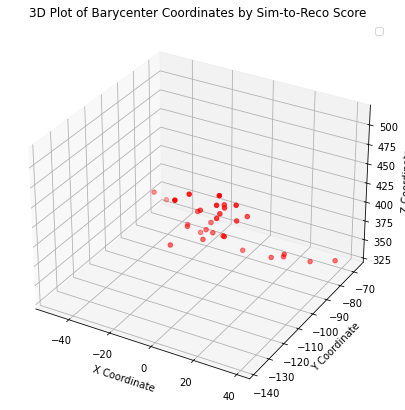

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import awkward as ak
import numpy as np

k = 0

# Extract the data for the first event
event_bx = bx[k]  # X coordinates for event 0
event_by = by[k]  # Y coordinates for event 0
event_bz = bz[k]  # Z coordinates for event 0

# Convert to NumPy for easier handling
event_bx = ak.to_numpy(event_bx)
event_by = ak.to_numpy(event_by)
event_bz = ak.to_numpy(event_bz)


# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(event_bx, event_by, event_bz, c='red')

# Set axis labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Plot of Barycenter Coordinates by Sim-to-Reco Score')

# Add legend
ax.legend()

# Show the plot
plt.show()
